In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint
from rouge import Rouge


from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Concatenate
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy, KLDivergence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

import matplotlib.pyplot as plt 
from keras.regularizers import l2
import os

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',', nrows=50000)

In [3]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cords batteri...
1,create a sketch in the neopoprealist manner of...,see image drawing develops stepbystep however ...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investors research pieces art buy som...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


In [4]:
df['headline'] = df['headline'].apply(lambda x : '_SOS_ '+ x + ' _EOS_')

In [5]:
df.head()

,headline,text
0,_SOS_ keep related supplies in the same area m...,photographer keep necessary lens cords batteri...
1,_SOS_ create a sketch in the neopoprealist man...,see image drawing develops stepbystep however ...
2,_SOS_ get a bachelors degree enroll in a studi...,possible become vfx artist without college deg...
3,_SOS_ start with some experience or interest i...,best art investors research pieces art buy som...
4,_SOS_ keep your reference materials sketches a...,start planning project work shall likely gathe...


/home/maksboruh/my_project_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


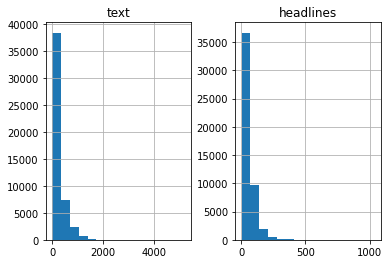

In [6]:
text_word_count = []
headlines_word_count = []

for i in df['text'].astype(str).values.tolist():
    text_word_count.append(len(i.split()))
for i in df['headline'].astype(str).values.tolist():
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [7]:
count = 0
for i in df['text'].astype(str).values.tolist():
    if(len(i.split())<=250):
        count += 1
print(count/len(df['text'].astype(str).values.tolist()))

0.6538069825233226


74% тексту менші за 350

In [8]:
count = 0
for i in df['headline'].astype(str).values.tolist():
    if(len(i.split())<=50):
        count += 1
print(count/len(df['headline'].astype(str).values.tolist()))

0.5988104452682609


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [11]:
train, val = train_test_split(train, test_size=0.056, random_state=42, shuffle=True)

In [12]:
train.shape

(44027, 2)

In [13]:
test.shape

(2455, 2)

In [14]:
val.shape

(2612, 2)

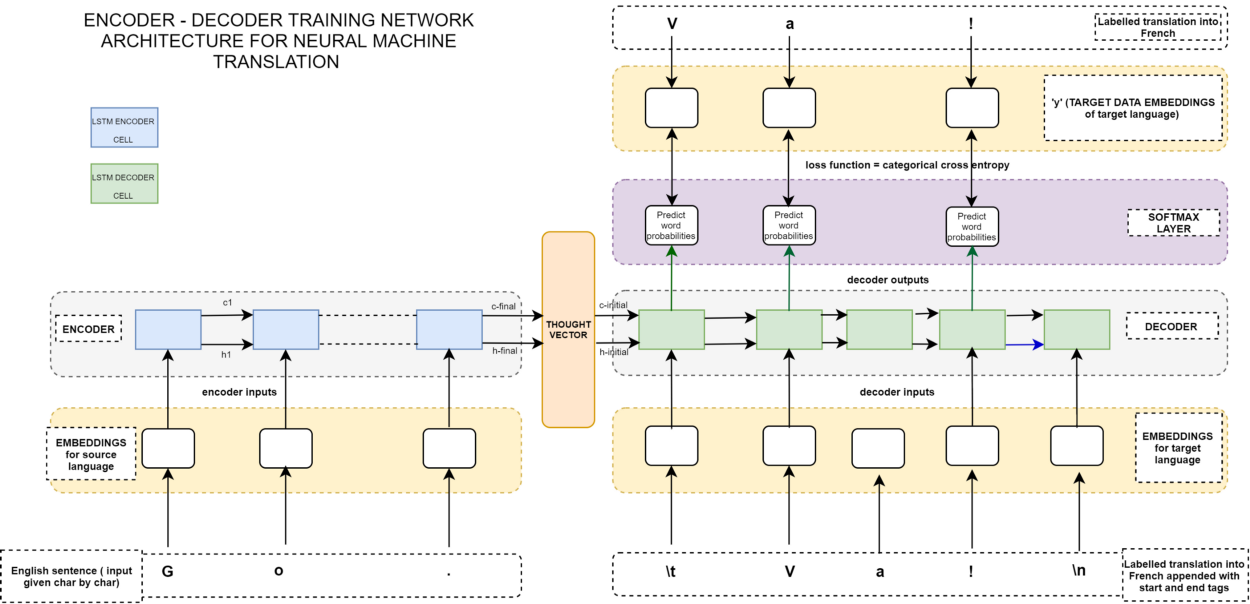

https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

In [15]:
# !wget 'http://nlp.stanford.edu/data/glove.6B.zip'

In [16]:
# !unzip '/home/maksboruh/course/text-summarization/program/glove.6B.zip'

In [17]:
max_len_text = 150 
max_len_summary = 50

In [18]:
X_train = train['text'].astype(str).values.tolist()
X_test = test['text'].astype(str).values.tolist()
X_val = val['text'].astype(str).values.tolist()

Y_train = train['headline'].astype(str).values.tolist()
Y_test = test['headline'].astype(str).values.tolist()
Y_val = val['headline'].astype(str).values.tolist()

Keras padding https://keras.io/guides/understanding_masking_and_padding/

In [19]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(X_train)
x_vocab = len(x_tokenizer.word_index) + 1
x_vocab = int(x_vocab*0.08)

x_tokenizer = Tokenizer(num_words=x_vocab)
x_tokenizer.fit_on_texts(X_train)

x_train = x_tokenizer.texts_to_sequences(X_train)
x_val = x_tokenizer.texts_to_sequences(X_val)

x_train = pad_sequences(x_train, maxlen=max_len_text, padding="post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding="post")

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(Y_train)
y_vocab = len(y_tokenizer.word_index) + 1
y_vocab = int(y_vocab*0.1)

y_tokenizer = Tokenizer(num_words=y_vocab)
y_tokenizer.fit_on_texts(Y_train)

y_train= y_tokenizer.texts_to_sequences(Y_train)
y_val = y_tokenizer.texts_to_sequences(Y_val)

y_train = pad_sequences(y_train, maxlen=max_len_summary, padding="post")
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding="post")

In [20]:
y_vocab

5264

In [21]:
x_vocab

16396

Tokenizer vocab https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work

Keras building seq2seq https://keras.io/examples/nlp/lstm_seq2seq/

In [22]:
batch_size = 512
epochs = 10
latent_dim = 400
embedding_dim = 100

In [23]:
embeddings_index = {}
f = open(os.path.join("/home/maksboruh/course/text-summarization/program/", 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [24]:
x_word_index = x_tokenizer.word_index
x_embedding_matrix = np.zeros((x_vocab, embedding_dim))
for word, i in x_word_index.items():
    if (i >= x_vocab):
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        x_embedding_matrix[i] = embedding_vector

In [25]:
y_word_index = y_tokenizer.word_index
y_embedding_matrix = np.zeros((y_vocab, embedding_dim))
for word, i in y_word_index.items():
    if (i >= y_vocab):
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        y_embedding_matrix[i] = embedding_vector

In [26]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,), name="encoder_in") 
# enc_emb_layer = Embedding(x_vocab, embedding_dim, mask_zero=True, name="encoder_emb")

enc_emb_layer = Embedding(x_vocab, embedding_dim, weights=[x_embedding_matrix], 
                            input_length=max_len_text, trainable=False, name="encoder_emb")
enc_emb = enc_emb_layer(encoder_inputs) 

# LSTM


#LSTM 1 
# encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True,
#                     dropout=0.4, recurrent_dropout=0.2, name="encoder_first_lstm") 
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_first_lstm", 
                    dropout=0.4, recurrent_dropout=0.2) 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 
encoder_states = [state_h, state_c]

# Decoder 
decoder_inputs = Input(shape=(None,), name="decoder_in") 
# dec_emb_layer = Embedding(y_vocab, embedding_dim, mask_zero=True, name="decoder_emb")
dec_emb_layer = Embedding(y_vocab, embedding_dim, weights=[y_embedding_matrix], 
                            trainable=False, name="decoder_emb")
dec_emb = dec_emb_layer(decoder_inputs) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_first_lstm") 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states) 

#Dense layer
decoder_dense = Dense(y_vocab, activation='softmax', name="decoder_dense") 
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_in (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
decoder_in (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
encoder_emb (Embedding)         (None, 150, 100)     1639600     encoder_in[0][0]                 
__________________________________________________________________________________________________
decoder_emb (Embedding)         (None, None, 100)    526400      decoder_in[0][0]                 
____________________________________________________________________________________________

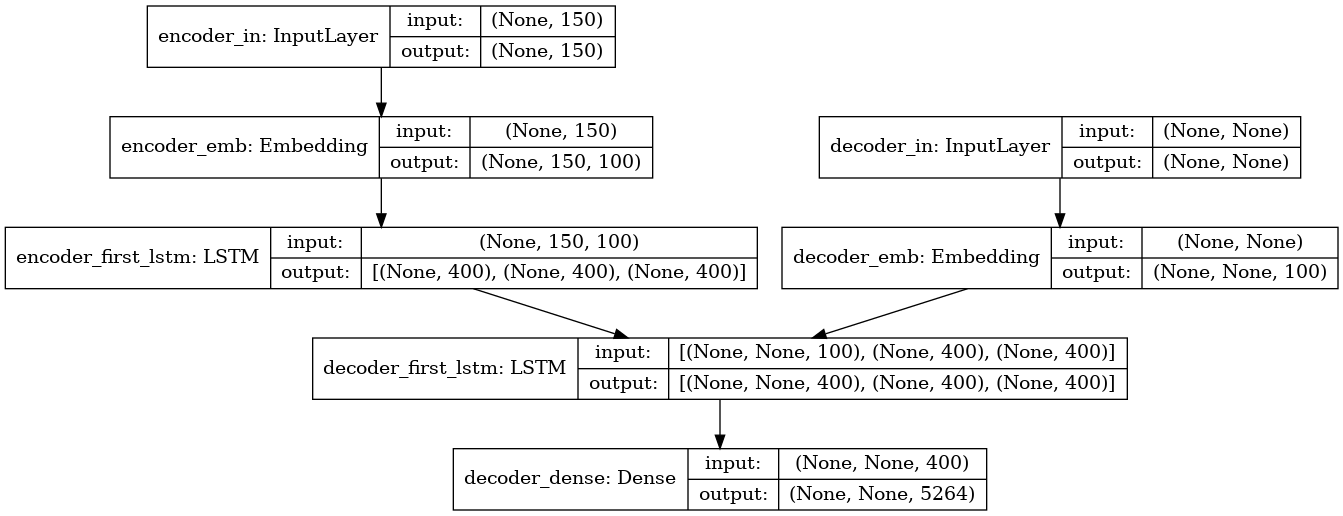

In [27]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [29]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=1)

In [30]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=epochs,
                  callbacks=[es],
                  batch_size=batch_size, 
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 44027 samples, validate on 2612 samples
Epoch 1/10
44027/44027 [==============================] - 366s 8ms/step - loss: 4.7866 - val_loss: 4.4215
Epoch 2/10
44027/44027 [==============================] - 364s 8ms/step - loss: 4.2294 - val_loss: 4.0888
Epoch 3/10
44027/44027 [==============================] - 365s 8ms/step - loss: 3.9940 - val_loss: 3.9049
Epoch 4/10
44027/44027 [==============================] - 364s 8ms/step - loss: 3.8310 - val_loss: 3.7716
Epoch 5/10
44027/44027 [==============================] - 364s 8ms/step - loss: 3.7067 - val_loss: 3.6687
Epoch 6/10
44027/44027 [==============================] - 365s 8ms/step - loss: 3.6065 - val_loss: 3.5890
Epoch 7/10
44027/44027 [==============================] - 365s 8ms/step - loss: 3.5240 - val_loss: 3.5271
Epoch 8/10
44027/44027 [==============================] - 364s 8ms/step - loss: 3.4532 - val_loss: 3.4779
Epoch 9/10
44027/44027 [==============================] - 364s 8ms/step - loss: 3.3916 - val_loss: 3.42

In [31]:
model.save("seq2seq_3")

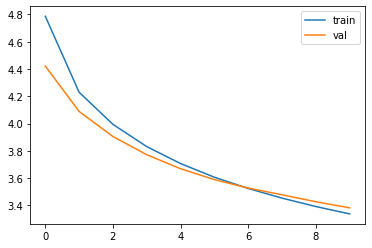

In [32]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend() 
pyplot.show()

In [33]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [34]:
model = load_model("seq2seq_2")

In [35]:
model

In [36]:
model.input

[<tf.Tensor 'encoder_in_1:0' shape=(None, 150) dtype=float32>,
 <tf.Tensor 'decoder_in_1:0' shape=(None, None) dtype=float32>]

In [37]:
model.layers

In [38]:
model.layers[4].output[1]

<tf.Tensor 'encoder_first_lstm_1/while:4' shape=(None, 400) dtype=float32>

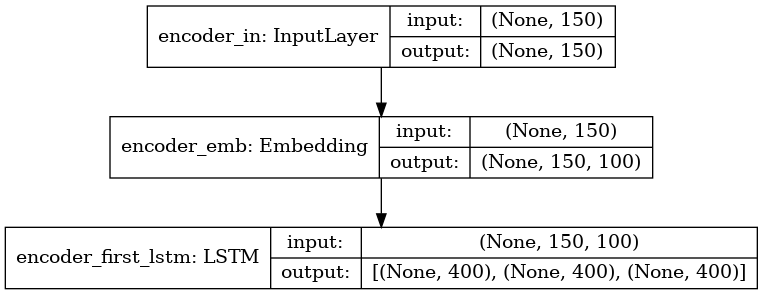

In [39]:
# encoder inference
encoder_inputs = model.input[0]

encoder_embedding_layer = model.layers[2]
encoder_embedding = encoder_embedding_layer(encoder_inputs)

encoder_outputs, state_h_enc, state_c_enc = model.layers[4](encoder_embedding) #last lstm layer
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
model.input[1]

<tf.Tensor 'decoder_in_1:0' shape=(None, None) dtype=float32>

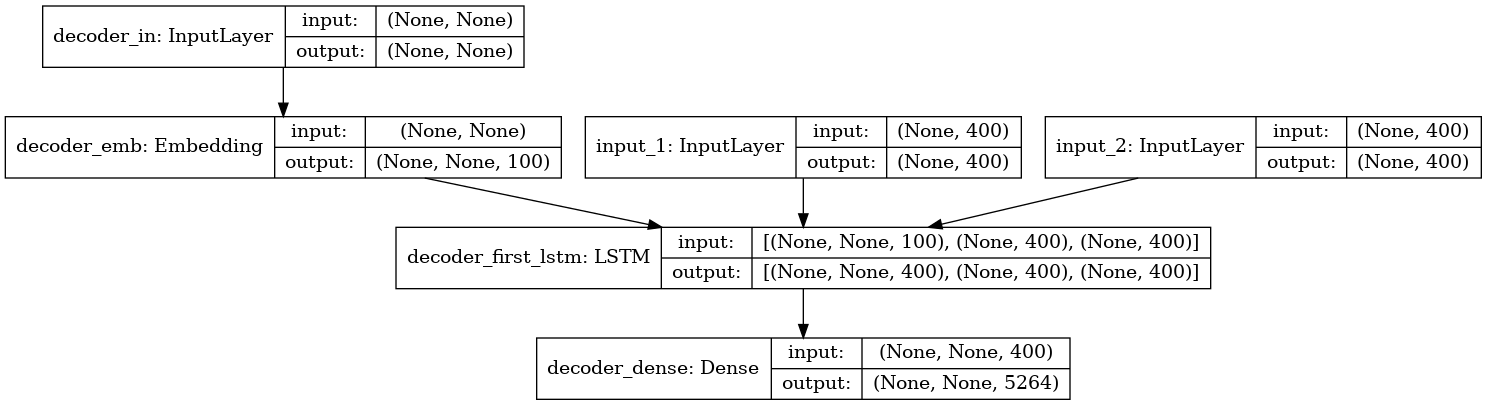

In [41]:
# decoder inference
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_layer = model.layers[3]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

Choosing next word https://arxiv.org/pdf/1904.09751.pdf

In [213]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [214]:
def n_max_elements(data, n):
    elems = []
    indexs = []
  
    for i in range(0, n): 
        max_ = 0
        index = 0
          
        for j in range(len(data)):     
            if data[j] > max_ and data[j] not in elems:
                max_ = data[j];
                index = j
                  
        elems.append(max_)
        indexs.append(index)
          
    return elems, indexs

In [228]:
def close_to_num(data, num):
    elem = 0
    index = 0
 
    for j in range(len(data)):     
        if data[j] > elem and data[j] < num:
            elem = data[j];
            index = j
          
    return elem, index

In [215]:
def top_k_sampling(data, k):
    pred = data[0]
    top_k_prob, top_k_index = n_max_elements(pred, k)
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [237]:
def nucleus_sampling(data, p):
    pred = data[0]
    sum_ = 0
    top_k_prob = []
    top_k_index = []
    prob = 1
    while sum_ <= p:
        prob, index = close_to_num(pred, prob)
        top_k_prob.append(prob)
        top_k_index.append(index)
        sum_ += prob
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [233]:
def beam_search_decoder(data, k=1):
    sequences = [[list(), 0.0]]
    
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [248]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :]    
#         sampled_token_index = beam_search_decoder(output_tokens[0, -1:], 2)[1][0][0]
        sampled_token_index = top_k_sampling(output_tokens[0, -1:], 10)
        sampled_token_index = nucleus_sampling(output_tokens[0, -1:], 0.25)
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eos':
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eos' or len(decoded_sentence.split()) > max_len_summary:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        states_value = [h, c]

    return decoded_sentence

In [43]:
def seq2summary(input_seq):
    summary=''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sos']) and i != target_word_index['eos']:
            summary += reverse_target_word_index[i]+' '           
    return summary

def seq2text(input_seq):
    return x_tokenizer.sequences_to_texts([input_seq])[0]

In [104]:
i=5
print("Review:", seq2text(x_val[i]))
print("\nOriginal summary:", seq2summary(y_val[i]))
print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
print("\n\n")

print("Review:", seq2text(x_train[i]))
print("\nOriginal summary:", seq2summary(y_train[i]))
print("\nPredicted summary:", decode_sequence(x_train[i].reshape(1, max_len_text)))
print("\n\n")

Review: order hair ringlets needs wet otherwise would bit dry begin rub hair towel cause frizz leave want done brush usually hair parted middle keep sections three side bring position vertical manner twist continue bringing reached end hair might usually take hours

Original summary: place the at the root of your head slowly making sure that the will not loosen the grip on your hair twist the as you twist the make sure your hair is being twisted along with it continue the process with the rest of the sections leave to dry 

Predicted summary:  use a hair dryer to your hair apply a conditioner to your hair



Review: involved project activities like leaning tables even sitting chairs give enough back support create muscle knots instance may notice normally sit weird angle watching television maybe slump left car create muscle knots shoulders back try pay attention position people love gently remind notice slouching awkward position meditation help aware posture well assist relaxing noti

In [250]:
i=3
print("Review:", seq2text(x_val[i]))
print("\nOriginal summary:", seq2summary(y_val[i]))
print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
print("\n\n")

print("Review:", seq2text(x_train[i]))
print("\nOriginal summary:", seq2summary(y_train[i]))
print("\nPredicted summary:", decode_sequence(x_train[i].reshape(1, max_len_text)))
print("\n\n")

Review: use shirt sweater good way completely cover show little bit cute choose seethrough youd like sweater sweater fairly large holes good option reduce amount skin showing reveal bit long sweater black pants black boots day night look show little bit staying modest wear vneck sweater shirt doesnt come far reveal chest make sure top low enough would show top trimmed lace wear vneck shirt shows trim works best longsleeved shirt sweater shirt fairly loose allow shirt fall one shoulder reveals strap cotton sweater sleeves rolled pair sweater white pants sandals day great option control much skin want show one two buttons show trim bra shirt enough top white buttondown shirt black slacks brightly colored stilettos ballerina flats night

Original summary: wear the under a sweater show only a of the go for an look wear a buttondown shirt over the 

Predicted summary:  wear a dress dress wear your jeans with a pair of your dress wear a dress with a jacket wear a shirt wear a jacket



Revie

Виродження тексту
https://dasha.ai/en-us/blog/neural-text-degeneration
https://stackoverflow.com/questions/46924452/what-to-do-when-seq2seq-network-repeats-words-over-and-over-in-output

In [183]:
states_value = encoder_model.predict(x_val[i].reshape(1, max_len_text))
                                     

target_seq = np.zeros((1, 1))

# Chose the 'start' word as the first word of the target sequence
target_seq[0, 0] = target_word_index['sos']

decoded_sentence = ''
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
   
# sampled_token_index = beam_search_decoder(output_tokens[0, -1:], 2)[1][0][0]
sampled_token_index = top_k_sampling(output_tokens[0, -1:], 3)


sampled_token = reverse_target_word_index[sampled_token_index]

In [184]:
sampled_token

'wear'

In [148]:
len(output_tokens[0,-1:][0])

5264

In [46]:
assert(False)

AssertionError: 

In [ ]:
# def beam_search_decoder(data, k):
#     sequences = [[list(), 0.0]]
#     # walk over each step in sequence
#     for row in data:
#         all_candidates = list()
#         # expand each current candidate
#         for i in range(len(sequences)):
#             seq, score = sequences[i]
#             for j in range(len(row)):
#                 candidate = [seq + [j], score - np.log(row[j])]
#                 all_candidates.append(candidate)
#         # order all candidates by score
        
#         ordered = sorted(all_candidates, key=lambda tup:tup[1])
#         # select k best
#         sequences = ordered[:k]
#     return sequences

In [ ]:
# data = [[0.1, 0.2, 0.3, 0.4, 0.5]]
# data = np.array(data)
# # decode sequence
# result = beam_search_decoder(data, 3)

In [ ]:
# result

In [ ]:
# for seq in result:
# 	print(seq)

In [ ]:
# e_out, e_h, e_c = encoder_model.predict(x_val[0].reshape(1, max_len_text))
# target_seq = np.zeros((1,1))

#     # Chose the 'start' word as the first word of the target sequence
# target_seq[0, 0] = target_word_index['sos']

# output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

In [ ]:
# output_tokens[0][0]

In [ ]:
# beam_search_decoder(output_tokens[0, -1:], 1)

In [ ]:
# reverse_target_word_index

In [ ]:
for i in range(1):
    print("Review:", seq2text(x_val[i]))
    print("\nOriginal summary:", seq2summary(y_val[i]))
    print("\nPredicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
    print("\n\n")

In [ ]:
for i in range(1):
    print("Review:", seq2text(x_train[i]))
    print("\nOriginal summary:", seq2summary(y_train[i]))
    print("\nPredicted summary:", decode_sequence(x_train[i].reshape(1, max_len_text)))
    print("\n\n")

Keras doc
https://keras.io/guides/working_with_rnns/

In [ ]:
# vocab = calc_vocab(train['text'])

In [ ]:
# vocab

In [ ]:
# vocab = int(vocab/2)

In [ ]:
# y_vocab = calc_vocab(train['headline'])

In [ ]:
# y_vocab

In [ ]:
# y_vocab = int(y_vocab/2)

In [ ]:
maxlen = 80
embed_dim = 120
batch_size = 32
latent_dim = 80
max_sum_len = 10

In [ ]:
x_tokenizer = Tokenizer(num_words=6000)
x_tokenizer.fit_on_texts(train['text'])

x_train = x_tokenizer.texts_to_sequences(train['text'])
x_val = x_tokenizer.texts_to_sequences(val['text'])

x_train = pad_sequences(x_train, maxlen)
x_val = pad_sequences(x_val, maxlen)

In [ ]:
x_vocab = len(x_tokenizer.word_index) + 1

In [ ]:
encoder_inputs = Input(shape=(maxlen,))
emb_layer = Embedding(x_vocab, embed_dim)
x = emb_layer(encoder_inputs)
# encoder_lstm_1 = LSTM(200, activation='relu', return_sequences=True, dropout=0.1)(x)
# encoder_lstm_2 = LSTM(120, activation='sigmoid', return_sequences=True, dropout=0.2)(encoder_lstm_1)
encoder_lstm_3 = LSTM(latent_dim, activation='relu')(x)

In [ ]:
decoded = RepeatVector(latent_dim)(encoder_lstm_3)

# decoder_inputs = Input(shape=(max_sum_len,)) 
# dec_emb_layer = Embedding(vocab, embed_dim, input_length = max_sum_len) 
# dec_emb = dec_emb_layer(decoder_inputs) 

# decoder_conc = concatenate([decoded, dec_emb])
decoder_lstm = LSTM(100, return_sequences=True) (decoded)
decoder_outputs = TimeDistributed(Dense(6000, activation='softmax'))(decoder_lstm)

In [ ]:
seq2seq_Model = Model(encoder_inputs, decoder_outputs) 
seq2seq_Model.summary()

In [ ]:
plot_model(seq2seq_Model, to_file='test.png', show_shapes=True, show_layer_names=True)

In [ ]:
seq2seq_Model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1,
                   patience = 3)

mc = ModelCheckpoint('best_sum_model.h5',
                    monitor = 'val_loss',
                    mode = 'min',
                    verbose = 1,
                    save_best_only = True)

In [ ]:
history = seq2seq_Model.fit(x_train, np.expand_dims(x_train, -1), 
                            batch_size=32, 
                            callbacks = [es, mc],
                            epochs=15,
                            validation_data = (x_val, np.expand_dims(x_val, -1)))

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize = (11,8))
pyplot.plot(history.history['loss'], label = 'train', color = 'blue')
pyplot.plot(history.history['val_loss'], label = 'val', color = 'orange')

pyplot.legend()
pyplot.show()

In [ ]:
def get_scores_rouge(text, prediction):
    rouge = Rouge()
    scores = rouge.get_scores(prediction, text)
    return scores

In [ ]:
def get_predicted_text(text, maxlen=maxlen):
    seqs = x_tokenizer.texts_to_sequences([text])
    pad_seqs = pad_sequences(seqs, maxlen)
    res = seq2seq_Model.predict(pad_seqs)
    print(pad_seqs[0])
    ty = x_tokenizer.sequences_to_texts(pad_seqs)
    rr = ' '.join(ty)
    return rr

In [ ]:
pred = get_predicted_text(list(test['text'])[0])

In [ ]:
pred

In [ ]:
# list(test['headline'])[0]

In [ ]:
# pprint(get_scores_rouge(list(test['headline'])[0], pred))

In [ ]:
# pred = get_predicted_text(list(train['text'])[0])

In [ ]:
# pred

In [ ]:
# list(train['headline'])[0]

In [ ]:
# pprint(get_scores_rouge(list(train['headline'])[0], pred))

In [ ]:
def rouge_min(texts, rouge, metric):
    min_s = np.inf
    for text in texts:
        score = get_scores_rouge(text, get_predicted_text(text))[0].get(rouge).get(metric)
        if score < min_s:
            min_s = score
    return min_s

In [ ]:
# rouge_min(list(test['text']), 'rouge-l', 'p')

In [ ]:
# rouge_min(list(test['text']), 'rouge-l', 'r')

In [ ]:
# rouge_min(list(test['text']), 'rouge-l', 'f')